# Chapter 5: Compare NOAA/NSIDC SIC CDR to Other SIC Data
* **Creators:** Ann Windnagel and Robyn Marowitz
* **Affiliation:** [National Snow and Ice Data Center (NSIDC)](https://nsidc.org/home "National Snow and Ice Data Center")
* **History:**
  * 8 January 2025 - Initial version

## Overview

In this notebook, you will learn how to calculate the sea ice extent (SIE) for another sea ice concentration product from [EUMETSAT Ocean and Sea Ice Satellite Application Facility](https://osi-saf.eumetsat.int/products/osi-450-a "Ocean and Sea Ice Satellite Application Facility") (OSI-SAF) and compare it to the calculation of the sea ice extent from the NOAA/NSIDC SIC CDR data that you computed in Notebook 4. If you have not completed Notebook 4, go back and do that before continuing with this notebook. The OSI-SAF SIC data are processed with a different sea ice algorithm than the NOAA/NSIDC SIC CDR. It can be instructive to compare different algorithms to see how the extent calculations can differ but that the overall trend in sea ice is still similar.

<div class="alert alert-block alert-info">
<h3><strong>Note</strong></h3>
The OSI-SAF data are on a 25 km <a href="https://nsidc.org/data/user-resources/help-center/guide-ease-grids" title="A Guide to EASE Grids">Equal-Area Scalable Earth 2 (EASE2) Grids</a>. The EASE2 Grids utilize an equal-area projection which minimizes the amount of distortion over the poles. This means that all the grid cells have the same area. Since areas don't change between grid cells, visualization and intercomparison operations are greatly simplified and analysis is more convenient. This will be important to note when the sea ice extent is calculated from these data later in this notebook.
</div>

### Prerequisites
Read and understand the material in Notebook 1, Notebook 2, and Notebook 4.

### Targeted Level
Intermediate

### Learning Outcomes
Once you have completed this notebook, you will be able to:
* Compute sea ice extent for one year of gridded sea ice concentration data from OSI-SAF
* Plot two seas ice extent time series together to compare them

### Time Estimate
TBD

<div class="alert alert-block alert-info">
<h3><strong>Note</strong></h3>
This notebook utilizes four data files that were pre-processed to work with this notebook. The necessary files are in the <code>data_files</code> directory in this repository. Two of these files are the OSI-SAF sea ice concentration netCDF files: <code>osi-saf-sic-sh-2023.nc</code> and <code>osi-saf-sic-nh-2012.nc</code>. The other two files are CSV files created in Notebook 4 and saved to your local machine, if you chose to do so, in the <code>data-files</code> directory. The names of these files are <code>cdr_sie_SH_2023.csv</code> and <code>cdr_sie_NH_2012.csv</code>. These files have also been included in the GitHub repository, so it is not necessary to have saved them when you completed Notebook 4.
</div>

### Import relevant packages

In [1]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import netCDF4
from netCDF4 import Dataset
from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

************************
## Tutorial

Calculate sea ice extent for OSI-SAF data and plot a time series graph with the CDR sea ice extent data
*************************
### Open and Read the OSI-SAF Southern Hemisphere 2023 SIC Data

In Notebook 5, you will not have to access the CDR SIC STAC catalog because the processed data needed has already been saved to CSV files. You will need to open a netCDF file containing the OSI-SAF SIC data. You will use the NetCDF4 python library for this.

In [2]:
# Read in OSI-SAF 2023 Southern Hemisphere SIC data
osisaf_sic_2023_fn = 'data_files/osi-saf-sic-sh-2023.nc'
osisaf_sic_2023_nc = Dataset(osisaf_sic_2023_fn, 'r')

### List the Variables in the OSI-SAF File

From the listing, you can see that there is an `ice_conc` variable. Looking at the metadta for that, you can see that is the variable you will want to use. Note the `valid_min` of 0, the `valid_max` of 10000, and the `scale_factor` of 0.01 on the `ice_conc` data. Taking the `scale_factor` into account, means the valid range of the data are 0 to 100%. This means we will not have to convert the data to percent like we did for the CDR SIC data in Notebook 4. 

In addition, there is a `time` variable you will need to keep track of the date of the sea ice extent that you calculate. Note that the units of the `time` variable is "seconds since 1978-01-01 00:00:00". You will need this information when you extract the time data to convert it to a human readable date.

In [3]:
# Look at the available variables
print("OSI-SAF variables: ", osisaf_sic_2023_nc.variables.keys())
print("\n") # print blank line

# Look at the ice_conc variable
print("ice_conc: \n", osisaf_sic_2023_nc.variables['ice_conc'])
print("\n") # print blank line

# Look at the time variable
print("time: \n", osisaf_sic_2023_nc.variables['time'])

OSI-SAF variables:  dict_keys(['Lambert_Azimuthal_Grid', 'time', 'time_bnds', 'xc', 'yc', 'lat', 'lon', 'ice_conc', 'raw_ice_conc_values', 'total_standard_uncertainty', 'smearing_standard_uncertainty', 'algorithm_standard_uncertainty', 'status_flag'])


ice_conc: 
 <class 'netCDF4._netCDF4.Variable'>
int32 ice_conc(time, yc, xc)
    _FillValue: -32767
    long_name: fully filtered concentration of sea ice using atmospheric correction of brightness temperatures and open water filters
    standard_name: sea_ice_area_fraction
    units: %
    valid_min: 0
    valid_max: 10000
    grid_mapping: Lambert_Azimuthal_Grid
    coordinates: lat lon
    scale_factor: 0.01
    comment: this field is the primary sea ice concentration estimate for this climate data record
    ancillary_variables: total_standard_uncertainty status_flag
    cell_methods: time: mean
unlimited dimensions: time
current shape = (365, 432, 432)
filling on


time: 
 <class 'netCDF4._netCDF4.Variable'>
float64 time(time)
    

### Extract the Sea Ice Concentration Data from OIS-SAF File

In [4]:
# Pull out sea ice concentration variable into numpy array
osisaf_seaice_conc_2023_var = osisaf_sic_2023_nc.variables['ice_conc']
osisaf_seaice_conc_2023_np = osisaf_seaice_conc_2023_var[:]

### Calculate Sea Ice Extent from OSI-SAF Data

Calculating sea ice extent from the OSI-SAF data is very similar to the method used when computing it from the SIC CDR data in Notebook 4. The main difference is that, as noted at the top of this Notebook, the OSI-SAF SIC data is on the EASE2 projection and grid. Since this is an equal area grid, you will not need a separate pixel area file as you did in Notebook 4 when calculating extent from the SIC CDR data. The spatial resolution of the OSI-SAF data is 25 km x 25 km or 625 sq km for each grid cell. You will see that when you come to the step where you multiply the grid cells with sea ice by the area of the grid cell, you simply multiply by 625. 

In [5]:
# Extract time and convert to human readable format
osisaf_time_2023 = osisaf_sic_2023_nc.variables['time']
osisaf_time_2023_np = osisaf_time_2023[:]

# Convert to human readable date based on the units being "seconds since 1978-01-01 00:00:00"
delta = timedelta(seconds=int(osisaf_time_2023_np[0]))
human_date = date(1978,1,1) + delta

# Extract the year of the data
year=datetime.strftime(human_date, '%Y')

# Create an empty list to store sea ice extent data
sie_list = []

# Calculate daily extent for each day and save to a pandas dataframe
for t in range(len(osisaf_seaice_conc_2023_np)):
    # Here we are squeezing so we have a 2D array for each day
    osisaf_seaice_conc_2d = np.copy(osisaf_seaice_conc_2023_np[t,:,:].squeeze())
    
    # Round to the nearest percent so that we work with whole numbers. 
    # This alleviates any issues with round off error when we threshold the extent at 15%
    osisaf_seaice_conc_2d = np.round(osisaf_seaice_conc_2d, 1)

    # Compute Extent
    # Create mask to filter out the flag values from the computation and concentrations less than 15%
    # Fill value is -32767
    # This line removes fill values and concentration < 15%
    flag_mask_extent = ma.masked_outside(osisaf_seaice_conc_2d, 15, 100)

    # Set all remaining grid cells that contain sea ice concentraiton to 1
    non_mask_extent = ma.nonzero(flag_mask_extent)
    flag_mask_extent[non_mask_extent] = 1.0

    # Mulitply the grid cells with sea ice by the area of the grid cell
    osisaf_sie_raster = flag_mask_extent * 625

    # Sum all grid cells to get a total sea ice extent
    osisaf_sie_total = osisaf_sie_raster.sum()

    # Set the day of year (doy)
    doy = t + 1 
    # Create the date from the year and the day of year (doy) for the SIE just computed
    my_date = datetime.strptime(f'{year} {doy}', '%Y %j')

    # Add the SIE and the date to the list
    sie_list.append(
        {
            'yyyy-mm-dd': my_date, 
            'osisaf_extent': osisaf_sie_total
        }
    )

# Create pandas dataframe from list
osisaf_extent_2023_df = pd.DataFrame(sie_list)

### Review the Data in the Dataframe

In [6]:
# Set display options for pandas
pd.options.display.float_format = '{:20,.2f}'.format

# Show dataframe
osisaf_extent_2023_df.head()

,yyyy-mm-dd,osisaf_extent
0,2023-01-01,"5,317,500.00"
1,2023-01-02,"5,183,125.00"
2,2023-01-03,"5,024,375.00"
3,2023-01-04,"4,838,750.00"
4,2023-01-05,"4,748,125.00"


### Open the CSV file that contains the 2023 Southern Hemisphere CDR sea ice extent created in Notebook 4

In [7]:
# Read in CDR csv file, set date to datetime format, and rename columns to make it easier to merge with the OSI-SAF data
cdr_2023_fn = 'data_files/cdr_sie_SH_2023.csv'
cdr_extent_2023_df = pd.read_csv(cdr_2023_fn,parse_dates=True)
cdr_extent_2023_df['yyyy/mm/dd'] = pd.to_datetime(cdr_extent_2023_df['yyyy/mm/dd'])
cdr_extent_2023_df = cdr_extent_2023_df.rename(columns={'yyyy/mm/dd': 'yyyy-mm-dd', 'Extent(km2)': 'cdr_extent'})

# Show dataframe
cdr_extent_2023_df.head()

,yyyy-mm-dd,cdr_extent
0,2023-01-01,"4,969,503.44"
1,2023-01-02,"4,737,612.40"
2,2023-01-03,"4,637,743.40"
3,2023-01-04,"4,478,236.57"
4,2023-01-05,"4,345,070.47"


### Merge the two dataframes by date

Merging the two sea ice extent data frames by date will make them easier to plot.

In [8]:
# Merge dataframes by date
merged_df = pd.merge(osisaf_extent_2023_df, cdr_extent_2023_df, how='inner', on = 'yyyy-mm-dd')

# Show dataframe
merged_df.head()

,yyyy-mm-dd,osisaf_extent,cdr_extent
0,2023-01-01,"5,317,500.00","4,969,503.44"
1,2023-01-02,"5,183,125.00","4,737,612.40"
2,2023-01-03,"5,024,375.00","4,637,743.40"
3,2023-01-04,"4,838,750.00","4,478,236.57"
4,2023-01-05,"4,748,125.00","4,345,070.47"


### Plot the two data sets together to compare
This exercise highlights how different processing of similar data can lead to slightly different output. Note that the OSISAF sea ice extent is consistently slightly higher than the CDR SIE. Neither data product is wrong since their curves are similar but there are reasons for the differences.
The potential reasons are:
* Different algorithm using a different combination of channels (frequencies/polarizations) that have a different sensitivity to the ice/water threshold.
* Different weather filters, which have the effect of defining the ice edge by removing some low concentration ice.
* Different land spillover filter.
* Different land mask.

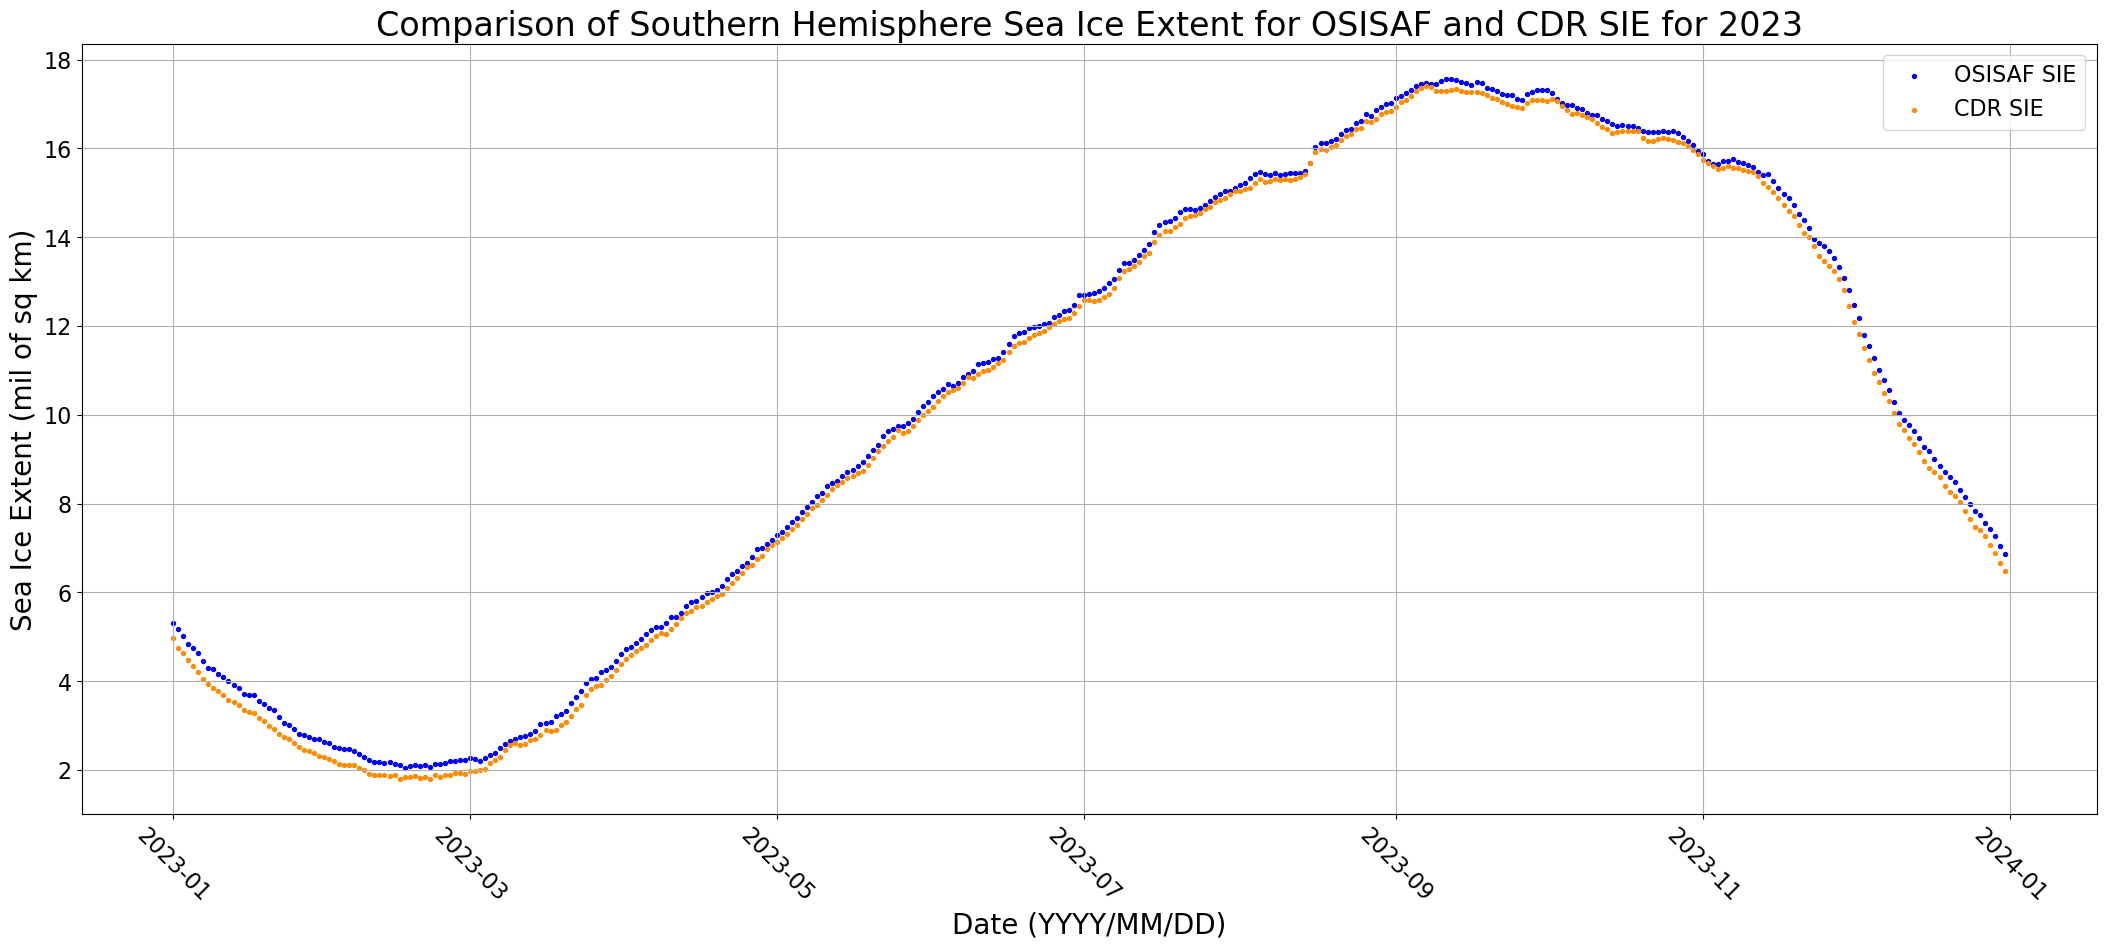

In [9]:
# Set up plot space
fig, ax1 = plt.subplots(figsize=(26, 10))

# Plot the two data sets
plt.scatter(merged_df['yyyy-mm-dd'], merged_df['osisaf_extent']/10e5, color='blue', 
            label='OSISAF SIE', s=8)
plt.scatter(merged_df['yyyy-mm-dd'], merged_df['cdr_extent']/10e5, color='darkorange', 
            label='CDR SIE', s=8)

# Set labels and ticks
plt.ylabel("Sea Ice Extent (mil of sq km)", fontsize=20)
plt.title("Comparison of Southern Hemisphere Sea Ice Extent for OSISAF and CDR SIE for 2023", fontsize=24)
plt.xlabel("Date (YYYY/MM/DD)", fontsize=20)
plt.ylabel("Sea Ice Extent (mil of sq km)", fontsize=20)
plt.xticks(rotation=-45, fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.grid()

<div class="alert alert-block alert-success">
<h3><strong>Exercise</strong></h3>
Using the example from this Tutorial, uncomment the template below, and change the code as necessary to calculate sea ice extent for the Northern Hemisphere OSI-SAF data for 2012 and plot it with the 2012 CDR sea ice extent. </br></br>
<strong>Be sure to update variable names and plot titles as appropriate.</strong>
</div>

### Read and Extract the OSI-SAF Northern Hemisphere 2012 SIC Data

In [10]:
# Read in OSI-SAF 2012 Northern Hemisphere SIC data
# NOTE: the NH filename has been updated for you here, but the variable names have not
#osisaf_sic_2023_fn = 'data_files/osi-saf-sic-nh-2012.nc' # Uncomment out this command and update as necessary
#osisaf_sic_2023_nc = Dataset(osisaf_sic_2023_fn, 'r') # Uncomment out this command and update as necessary

# Pull out sea ice concentration variable into numpy array
#osisaf_seaice_conc_2023_var = osisaf_sic_2023_nc.variables['ice_conc'] # Uncomment out this command and update as necessary
#osisaf_seaice_conc_2023_np = osisaf_seaice_conc_2023_var[:] # Uncomment out this command and update as necessary

### Calculate Sea Ice Extent

In [11]:
# Extract time and convert to human readable format
#osisaf_time_2023 = osisaf_sic_2023_nc.variables['time'] # Uncomment out this command and update as necessary
#osisaf_time_2023_np = osisaf_time_2023[:] # Uncomment out this command and update as necessary

# Convert to human readable date based on the units being "seconds since 1978-01-01 00:00:00"
#delta = timedelta(seconds=int(osisaf_time_2023_np[0])) # Uncomment out this command and update as necessary
#human_date = date(1978,1,1) + delta # Uncomment out this command and update as necessary

# Extract the year of the data
#year=datetime.strftime(human_date, '%Y') # Uncomment out this command and update as necessary

# Create an empty list to store sea ice extent data
#sie_list = [] # Uncomment out this command

# Calculate daily extent for each day and save to a pandas dataframe
#for t in range(len(osisaf_seaice_conc_2023_np)):
    # Here we are squeezing so we have a 2D array for each day
    #osisaf_seaice_conc_2d = np.copy(osisaf_seaice_conc_2023_np[t,:,:].squeeze()) # Uncomment out this command and update as necessary
    
    # Round to the nearest percent so that we work with whole numbers. 
    # This alleviates any issues with round off error when we threshold the extent at 15%
    #osisaf_seaice_conc_2d = np.round(osisaf_seaice_conc_2d, 1) # Uncomment out this command

    # Compute Extent
    # Create mask to filter out the flag values from the computation and concentrations less than 15%
    # Fill value is -32767
    # This line removes fill values and concentration < 15%
    #flag_mask_extent = ma.masked_outside(osisaf_seaice_conc_2d, 15, 100) # Uncomment out this command

    # Set all remaining grid cells that contain sea ice concentraiton to 1
    #non_mask_extent = ma.nonzero(flag_mask_extent) # Uncomment out this command
    #flag_mask_extent[non_mask_extent] = 1.0 # Uncomment out this command

    # Mulitply the grid cells with sea ice by the area of the grid cell
    #osisaf_sie_raster = flag_mask_extent * 625 # Uncomment out this command

    # Sum all grid cells to get a total sea ice extent
    #osisaf_sie_total = osisaf_sie_raster.sum() # Uncomment out this command

    # Set the day of year (doy)
    #doy = t + 1 # Uncomment out this command
    # Create the date from the year and the day of year (doy) for the SIE just computed
    #my_date = datetime.strptime(f'{year} {doy}', '%Y %j') # Uncomment out this command

    # Add the SIE and the date to the list
    #sie_list.append( # Uncomment out this command
    #    { # Uncomment out this command
    #        'yyyy-mm-dd': my_date, # Uncomment out this command
    #        'osisaf_extent': osisaf_sie_total # Uncomment out this command
    #    } # Uncomment out this command
    #) # Uncomment out this command

# Create pandas dataframe from list
#osisaf_extent_2023_df = pd.DataFrame(sie_list) # Uncomment out this command and update as necessary

### Open the CSV file that contains the 2012 Northern Hemisphere CDR sea ice extent created in Notebook 4

In [12]:
# Read in CDR csv file, set date to datetime format, and rename columns to make it easier to merge with the OSI-SAF data
# NOTE: the NH filename has been updated for you here, but the variable names have not
#cdr_2023_fn = 'data_files/cdr_sie_NH_2012.csv' # Uncomment out this command and update as necessary
#cdr_extent_2023_df = pd.read_csv(cdr_2023_fn,parse_dates=True) # Uncomment out this command and update as necessary
#cdr_extent_2023_df['yyyy/mm/dd'] = pd.to_datetime(cdr_extent_2023_df['yyyy/mm/dd']) # Uncomment out this command and update as necessary
#cdr_extent_2023_df = cdr_extent_2023_df.rename(columns={'yyyy/mm/dd': 'yyyy-mm-dd', 'Extent(km2)': 'cdr_extent'}) # Uncomment this out, update as necessary

### Merge the OSI-SAF and CDR Extent Dataframes

In [13]:
# Merge dataframes by date
#merged_df = pd.merge(osisaf_extent_2023_df, cdr_extent_2023_df, how='inner', on = 'yyyy-mm-dd') # Uncomment out this command and update as necessary

# Show dataframe
#merged_df.head() # Uncomment out this command

### Plot the 2012 Northern Hemisphere OSI-SAF and CDR Extent Data

In [14]:
# Set up plot space
#fig, ax1 = plt.subplots(figsize=(26, 10)) # Uncomment out this command

# Plot the two data sets
#plt.scatter(merged_df['yyyy-mm-dd'], merged_df['osisaf_extent']/10e5, color='blue', # Uncomment out this command
#            label='OSISAF SIE', s=8) # Uncomment out this command
#plt.scatter(merged_df['yyyy-mm-dd'], merged_df['cdr_extent']/10e5, color='darkorange', # Uncomment out this command
#            label='CDR SIE', s=8) # Uncomment out this command

# Set labels and ticks
#plt.ylabel("Sea Ice Extent (mil of sq km)", fontsize=20) # Uncomment out this command
#plt.title("Comparison of Southern Hemisphere Sea Ice Extent for OSISAF and CDR SIE for 2023", fontsize=24) # Uncomment this out, updaate title
#plt.xlabel("Date (YYYY/MM/DD)", fontsize=20) # Uncomment out this command
#plt.ylabel("Sea Ice Extent (mil of sq km)", fontsize=20) # Uncomment out this command
#plt.xticks(rotation=-45, fontsize=16) # Uncomment out this command
#plt.yticks(fontsize=16) # Uncomment out this command
#plt.legend(fontsize=16) # Uncomment out this command
#plt.grid() # Uncomment out this command

### Next Steps

After successful completion of Notebook 5, you can go on to Notebook 6: Compare NOAA/NSIDC SIC with Surface Air Temperature.

### Data Statement

Meier, W. N., Fetterer, F., Windnagel, A. K., & Stewart, J. S. (2021). NOAA/NSIDC Climate Data Record of Passive Microwave Sea Ice Concentration. (G02202, Version 4). [Data Set]. Boulder, Colorado USA. National Snow and Ice Data Center. https://doi.org/10.7265/efmz-2t65.

### Metadata

* Language/Package(s)
  * Python
  * netcdf4
  * pandas
  * numpy
  * matplotlib
* Geophysical Keywords
  * Sea Ice Concentration

### Software License

Copyright 2025 NOAA NCAI

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the “Software”), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED “AS IS”, WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

### Content License

[CC BY 4.0](https://creativecommons.org/licenses/by/4.0/ "Createive Commons BY 4.0 License")

### Disclaimer

This Jupyter notebook is a scientific product and is not official communication of the National Oceanic and Atmospheric Administration, the United States Department of Commerce, the National Snow and Ice Data Center, or the University of Colorado at Boulder. All NOAA Jupyter notebooks are provided on an 'as is' basis, and the user assumes responsibility for its use. Any claims against the Department of Commerce or Department of Commerce bureaus stemming from the use of this Jupyter notebook will be governed by all applicable Federal law. Any reference to specific commercial products, processes, or services by service mark, trademark, manufacturer, or otherwise does not constitute or imply their endorsement, recommendation or favoring by the Department of Commerce. The Department of Commerce seal and logo, or the seal and logo of a DOC bureau, shall not be used in any manner to imply endorsement of any commercial product or activity by DOC or the United States Government.